Установите пакет https://github.com/markub3327/flappy-bird-gymnasium/tree/main с окружением FlappyBird-v0. Обучите агента для игры в Flappy Bird, используя любой алгоритм из семейства алгоритмов:

Вариант 1. Q-learning.

Вариант 2. Deep Q-learning.

Используя обертку RecordEpisodeStatistics, соберите статистику об эпизодах. Визуализируйте полученные данные. Используя обертку RecordVideo, запишите видео с демонстрацией обученного агента.

In [13]:
import numpy as np

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.8 MB/s eta 0:00:00


In [2]:
!pip install flappy-bird-gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.6 MB/s eta 0:00:00


In [90]:
import gymnasium as gym
import flappy_bird_gymnasium

env = gym.make("FlappyBird-v0", render_mode="human")
observation, info = env.reset()
rewards = 0
obs, _ = env.reset()
print(obs)
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    rewards += reward
    done = terminated or truncated

print(rewards)
env.close()

[ 1.         0.         1.         1.         0.         1.
  1.         0.         1.         0.4765625 -0.9        0.5      ]
8.99999999999998


In [4]:
env.observation_space.shape[0]

12

In [5]:
env.action_space

Discrete(2)

In [6]:
from collections import namedtuple, deque
import random

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen = capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
import torch as th

In [8]:
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        n_hidden= 12
        self.fc1 = nn.Linear(n_observations, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [9]:
from dataclasses import dataclass

@dataclass
class PolicyConfig:
    def __init__(self, observation_dim, action_dim, device, epsilon=0.5, lr=0.01, ucb_coefficient=1.0):
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.device = device
        self.epsilon = epsilon
        self.lr = lr
        self.ucb_coefficient = ucb_coefficient  # Add this line to include ucb_coefficient


In [10]:
class Policy:
    def __init__(self, policy_cfg: PolicyConfig):
        self.policy_cfg = policy_cfg
        self.action_counts = np.zeros(policy_cfg.action_dim)
        self.total_rewards = np.zeros(policy_cfg.action_dim)
        self.total_steps = 0
        self.policy_network = DQN(policy_cfg.observation_dim, policy_cfg.action_dim).to(policy_cfg.device)
        self.target_network = DQN(policy_cfg.observation_dim, policy_cfg.action_dim).to(policy_cfg.device)
        self.sync_models()

    def sync_models(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def get_ucb1_action(self, state: th.Tensor) -> int:
        # Используем UCB1 для выбора действия
        exploration_factor = np.sqrt(np.log(self.total_steps + 1) / (self.action_counts + 1e-6))
        action_values = self.total_rewards / (self.action_counts + 1e-6) + self.policy_cfg.ucb_coefficient * exploration_factor
        chosen_action = np.argmax(action_values)

        # Обновляем статистику
        self.action_counts[chosen_action] += 1
        self.total_steps += 1

        return chosen_action

    def get_best_action(self, state: th.Tensor) -> int:
        p = th.rand(1).item()
        if p < self.policy_cfg.epsilon:
            return self.get_ucb1_action(state)
        else:
            action = self.policy_network(state)
            return th.argmax(action).item()

    def save(self):
        th.save(self.policy_network.state_dict(), 'policy_network.pth')
        th.save(self.target_network.state_dict(), 'target_network.pth')


    def load(self):
        self.policy_network.load_state_dict(th.load('policy_network.pth'))
        self.target_network.load_state_dict(th.load('target_network.pth'))



In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(rewards_per_episode):
    plt.figure(figsize=(6, 3))
    plt.plot(rewards_per_episode)
    plt.title('Суммарные награды за каждый эпизод')
    plt.xlabel('Epoch')
    plt.ylabel('reward')
    plt.grid()
    plt.show()

In [16]:
import gymnasium as gym
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

In [17]:
@dataclass
class TrainConfig:
    discount: float = 0.95
    learning_rate: float = 0.001
    num_episodes: int = 10000
    batch_size: int = 128
    epsilon_decay: float = 0.995
    epsilon: float = 1.0
    final_epsilon: float = 0.3
    print_every: float = 500

In [18]:
class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy, plot_metrics):
        self.memory = ReplayMemory(capacity=30000)
        self.policy = policy
        self.env = env
        self.optimizer = optim.Adam(policy.policy_network.parameters(), lr=train_config.learning_rate)
        self.train_config = train_config
        self.criterion = nn.MSELoss().to(self.policy.policy_cfg.device)
        self.rewards=[]
        self.positions=[]
        self.plot_metrics = plot_metrics

    def train(self):
        max_diff=0
        reward=[]
        for episode in tqdm(range(self.train_config.num_episodes)):
            start_state, info = self.env.reset()
            start_state=start_state.to(self.policy.policy_cfg.device)
            r = self.run_episode(start_state)
            reward.append(r)

            self.train_config.epsilon = max( self.train_config.final_epsilon, self.train_config.epsilon*self.train_config.epsilon_decay)


            if reward[-1] >= max(reward):
                self.policy.save()
            self.generate_batch_and_fit()
            self.policy.sync_models()

            if episode % self.train_config.print_every == 0:
                self.rewards.append(th.mean(th.tensor(reward)))
                print(f"Episode: {episode}, reward = {self.rewards[-1]}")
        self.plot_metrics(self.rewards)

    def run_episode(self, start_state: th.Tensor):

        done=False
        state = start_state
        total_reward = 0
        # max_posit=-10
        # min_posit=10

        while not done:
            action = self.policy.get_best_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            next_state = th.FloatTensor(next_state).to(self.policy.policy_cfg.device)

            # Сохраняем переход в память
            transition = Transition(state, action, next_state, reward, done)
            self.memory.push(*transition)


            state = next_state
            total_reward += reward


        return total_reward#, max_posit, min_posit

    def generate_batch_and_fit(self):
        if len(self.memory) < self.train_config.batch_size:
            return

        transitions = self.memory.sample(self.train_config.batch_size)
        batch = Transition(*zip(*transitions))

        states = th.cat(batch.state).to(self.policy.policy_cfg.device)
        next_states = th.cat(batch.next_state).to(self.policy.policy_cfg.device)

        targets = self.policy.policy_network(states).to(self.policy.policy_cfg.device)
        next_state_targets = self.policy.target_network(next_states).to(self.policy.policy_cfg.device)

        for i, t in enumerate(transitions):
            if t.done:
                targets[i][t.action] = t.reward
            else:
                targets[i][t.action] = t.reward + self.train_config.discount * th.max(next_state_targets[i])

        self.fit_policy_network(states, targets)

    def fit_policy_network(self, X, y):
        self.optimizer.zero_grad()
        predictions = self.policy.policy_network(X)
        loss = self.criterion(predictions, y)
        loss.backward()
        self.optimizer.step()


In [19]:
class TransformObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super(TransformObservation, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)

    def observation(self, observation):
        return th.tensor(observation, dtype=th.float32).view(1, -1)

  0%|          | 15/10000 [00:00<02:16, 73.29it/s]

Episode: 0, reward = 2.0999999046325684


 10%|█         | 1008/10000 [00:19<03:49, 39.14it/s]

Episode: 1000, reward = 4.690310001373291


 20%|██        | 2008/10000 [00:46<03:22, 39.56it/s]

Episode: 2000, reward = 6.887805461883545


 30%|███       | 3006/10000 [01:15<03:03, 38.02it/s]

Episode: 3000, reward = 7.594467639923096


 40%|████      | 4005/10000 [01:43<02:43, 36.62it/s]

Episode: 4000, reward = 7.948338031768799


 50%|█████     | 5004/10000 [02:11<02:52, 28.99it/s]

Episode: 5000, reward = 8.161008834838867


 60%|██████    | 6005/10000 [02:39<01:50, 36.17it/s]

Episode: 6000, reward = 8.264105796813965


 70%|███████   | 7007/10000 [03:06<01:22, 36.11it/s]

Episode: 7000, reward = 8.369989395141602


 80%|████████  | 8008/10000 [03:34<00:53, 37.49it/s]

Episode: 8000, reward = 8.449118614196777


 90%|█████████ | 9005/10000 [04:02<00:27, 35.77it/s]

Episode: 9000, reward = 8.510320663452148


100%|██████████| 10000/10000 [04:30<00:00, 36.93it/s]


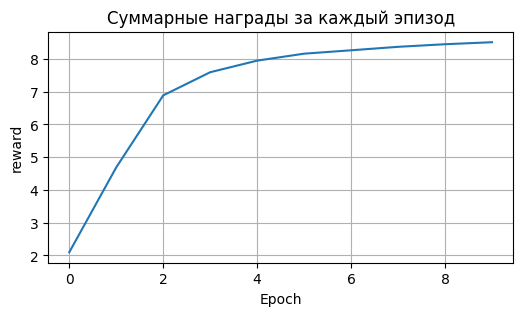

In [251]:
env = TransformObservation(gym.make("FlappyBird-v0"))
policy_config = PolicyConfig(observation_dim=12, action_dim=2, device='cuda' if th.cuda.is_available() else 'cpu', epsilon=0.001, lr=0.01, ucb_coefficient=0.99)
policy = Policy(policy_config)

trainer = Trainer(env, TrainConfig(batch_size=16, num_episodes=10000, print_every=1000), policy, plot_metrics)

trainer.train()

In [252]:
import gymnasium.wrappers as wrappers

In [280]:
policy.load()

env = TransformObservation(gym.make("FlappyBird-v0", render_mode="rgb_array"))
env = wrappers.RecordVideo(env, video_folder="/content/sample_data", episode_trigger=lambda x: (x+1) % 1 == 0)
total_reward=0
state, _ = env.reset()
state = th.tensor(state, dtype=th.float32).view(1, -1)
done = False
while not done:
    action = policy.get_best_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = th.tensor(next_state, dtype=th.float32).view(1, -1)
    done = terminated or truncated
    total_reward += reward
    state = next_state

env.close()
total_reward

<ipython-input-280-26f3023b064d>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = th.tensor(state, dtype=th.float32).view(1, -1)
<ipython-input-280-26f3023b064d>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = th.tensor(next_state, dtype=th.float32).view(1, -1)


Moviepy - Building video /content/sample_data/rl-video-episode-0.mp4.
Moviepy - Writing video /content/sample_data/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/sample_data/rl-video-episode-0.mp4


9.499999999999979

In [278]:
policy.load()

env = TransformObservation(gym.make("FlappyBird-v0", render_mode="rgb_array"))
env = wrappers.RecordVideo(env, video_folder="/content/sample_data", episode_trigger=lambda x: (x+1) % 1 == 0)
total_reward = 0
state, _ = env.reset()
state = th.tensor(state, dtype=th.float32).view(1, -1)
done = False
successful_attempt = False

while not done:
    action = policy.get_best_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = th.tensor(next_state, dtype=th.float32).view(1, -1)
    done = terminated or truncated
    total_reward += reward
    state = next_state

    # Проверка успешной попытки
    if done and total_reward > YOUR_SUCCESS_THRESHOLD:
        successful_attempt = True

env.close()

# Запись видео, если попытка была успешной
if successful_attempt:
    video_path = "/content/sample_data/successful_attempt.mp4"
    wrappers.convert_episode_to_video("/content/sample_data", video_path)
    print(f"Видео успешно записано по пути: {video_path}")

total_reward

<ipython-input-278-3d4eed281f2b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = th.tensor(state, dtype=th.float32).view(1, -1)
<ipython-input-278-3d4eed281f2b>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = th.tensor(next_state, dtype=th.float32).view(1, -1)


Moviepy - Building video /content/sample_data/rl-video-episode-0.mp4.
Moviepy - Writing video /content/sample_data/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/sample_data/rl-video-episode-0.mp4


NameError: ignored